## Variables à ajouter issues des recherches biblio

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 

In [1254]:
# !pip install ydata_profiling
!pip install tabulate


In [1254] used 0.0 MiB RAM in 4.55s (system mean cpu 2%, single max cpu 80%), peaked 0.0 MiB above final usage, current RAM usage now 1035.8 MiB


In [1255]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()



In [1255] used 0.0 MiB RAM in 0.10s (system mean cpu 17%, single max cpu 47%), peaked 0.0 MiB above final usage, current RAM usage now 1035.8 MiB


# TODO -- Introduction  (Business Understanding) 

## TODO Détermination objectifs métier , analytique du projet 

## TODO Identifier les contraintes , limites et risque du projet

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

### Chargement des différentes bases de données + étude du chargement en mémoire

In [1256]:
df = pd.read_csv("data/athlete_events.csv")
df = df[(df['Year'] > 2000) & (df['Season'] == 'Summer')]

In [1256] used -12.2 MiB RAM in 0.49s (system mean cpu 10%, single max cpu 100%), peaked 50.1 MiB above final usage, current RAM usage now 1023.6 MiB


In [1257]:
region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [1257] used 0.5 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 58%), peaked 0.0 MiB above final usage, current RAM usage now 1024.0 MiB


In [1258]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

7863240

In [1258] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 89%), peaked 0.0 MiB above final usage, current RAM usage now 1024.0 MiB


32534052 octets = 32,53 MB =  32534,052 KB.

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [1259]:
describe_csv("data/athlete_events.csv", delimiter=',')

0 M rows approx.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
---------------------------------------------------
data/athlete_events.csv
---------------------------------------------------
       Col     type   min    max  nulls optimal type
0     Name   object     -      -      -       object
1      Sex   object     -      -      -       object
2      Age  float64  10.0   97.0   9633         int8
3   Height  float64  0.01  226.0  67360      float16
4   Weight  float64  25.0  214.0  74749        int16
5     Team   object     -      -      -       object
6      NOC   object     -      -      -       object
7    Games   object     -      -      -       object
8     Year    int64  1896   2020      0        int16
9   Season   object     -      -      -       object
10    City   object     -      -      -       object
11   Sport   object     -      -      -       object
12   Event   object     -      -      -       object
13   Medal   object     -      -  

In [1260]:
describe_csv("data/noc_regions.csv", delimiter=',')
describe_csv("data/dictionary.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
data/noc_regions.csv
---------------------------------------------------
      Col    type min max nulls optimal type
0     NOC  object   -   -     -       object
1  region  object   -   -     -       object
2   notes  object   -   -     -       object

 0  rows
0 M rows approx.
1 
---------------------------------------------------
data/dictionary.csv
---------------------------------------------------
              Col     type         min            max nulls optimal type
0         Country   object           -              -     -       object
1            Code   object           -              -     -       object
2      Population  float64     10222.0   1371220000.0     5        int32
3  GDP per Capita  float64  277.068309  101449.968168    25      float32

 201  rows
In [1260] used 0.0 MiB RAM in 0.14s (system mean cpu 24%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 1033.8 Mi

In [1261]:
print(df.isnull().sum())

Name          0
Sex         159
Age         161
Height     7720
Weight    12653
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport       159
Event      9492
Medal     55132
dtype: int64
In [1261] used 0.8 MiB RAM in 0.12s (system mean cpu 6%, single max cpu 21%), peaked 0.0 MiB above final usage, current RAM usage now 1034.6 MiB


In [1262]:
df.describe()

,Age,Height,Weight,Year
count,65366.000000,57807.000000,52874.000000,65527.000000
mean,26.146315,161.991482,71.245300,2011.813695
std,5.622341,48.829024,15.868189,5.599671
min,12.000000,0.010000,28.000000,2004.000000
25%,22.000000,165.000000,60.000000,2008.000000
50%,25.000000,175.000000,69.500000,2012.000000
75%,29.000000,183.000000,80.000000,2016.000000
max,71.000000,226.000000,214.000000,2020.000000


In [1262] used 0.6 MiB RAM in 0.12s (system mean cpu 6%, single max cpu 25%), peaked 0.0 MiB above final usage, current RAM usage now 1035.2 MiB


In [1263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65527 entries, 1 to 282989
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    65527 non-null  object 
 1   Sex     65368 non-null  object 
 2   Age     65366 non-null  float64
 3   Height  57807 non-null  float64
 4   Weight  52874 non-null  float64
 5   Team    65527 non-null  object 
 6   NOC     65527 non-null  object 
 7   Games   65527 non-null  object 
 8   Year    65527 non-null  int64  
 9   Season  65527 non-null  object 
 10  City    65527 non-null  object 
 11  Sport   65368 non-null  object 
 12  Event   56035 non-null  object 
 13  Medal   10395 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 7.5+ MB
In [1263] used 0.6 MiB RAM in 0.12s (system mean cpu 8%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 1035.8 MiB


### Utilisation pandas_profiling

In [1264]:
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [1264] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 89%), peaked 0.0 MiB above final usage, current RAM usage now 1035.8 MiB


### EDA via pivottablejs

## EDA

### Terget Medals : Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction des autres variables.On effectue des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

#### Normalisation de certains pays

In [1265]:
# # RUSSIA
# df.loc[(df['Team'] == 'Soviet Union') & (df['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988
df.loc[(df['Team'] == 'ROC') & (df['NOC'] == 'ROC'), ['Team', 'NOC']] = ['Germany', 'RUS'] # JO 2020

# # GERMANY
# df.loc[(df['Team'] == 'East Germany') & (df['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df.loc[df['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df.loc[df['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']

In [1265] used 0.1 MiB RAM in 0.12s (system mean cpu 7%, single max cpu 39%), peaked 0.0 MiB above final usage, current RAM usage now 1035.9 MiB


#### Distribution of Age of Gold Medalists

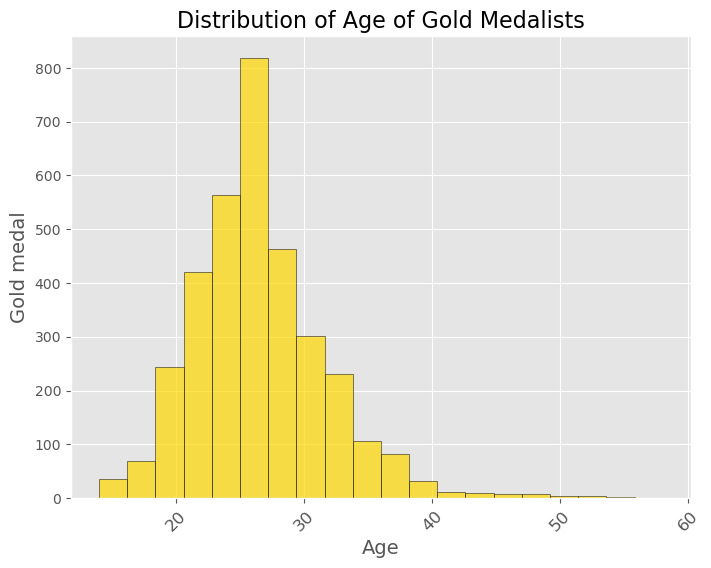

In [1266] used 2.1 MiB RAM in 0.22s (system mean cpu 8%, single max cpu 50%), peaked 3.2 MiB above final usage, current RAM usage now 1037.9 MiB


In [1266]:
gold_medals = df[df['Medal'] == 'Gold']

plt.figure(figsize=(8, 6))  
plt.hist(gold_medals['Age'], bins=20, color='gold', edgecolor='black', alpha=0.7)  

plt.title('Distribution of Age of Gold Medalists', fontsize=16)  
plt.xlabel('Age', fontsize=14)  
plt.ylabel('Gold medal', fontsize=14)  
plt.xticks(rotation=45, fontsize=12)  


plt.show()


#### Evolution du nombres de médailles gagnés par les favoris

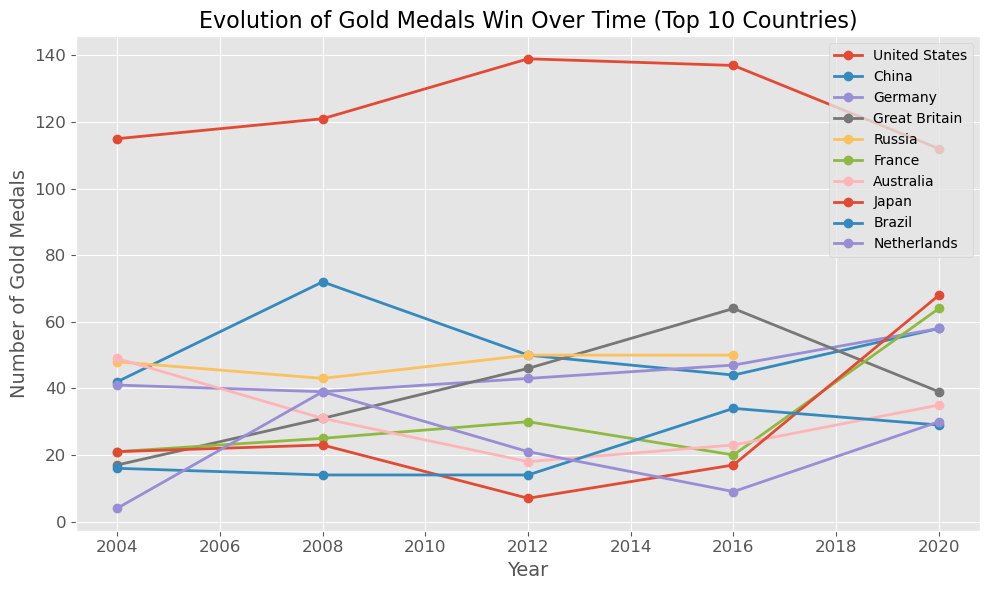

In [1267] used 1.0 MiB RAM in 0.30s (system mean cpu 10%, single max cpu 71%), peaked 0.0 MiB above final usage, current RAM usage now 1038.9 MiB


In [1267]:
import matplotlib.pyplot as plt

# Filter the data to include only gold medal winners
gold_medals = df[df['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_by_year_and_country.index, gold_medals_by_year_and_country[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution of Gold Medals Win Over Time (Top 10 Countries)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Evolution of Gold Medals per Athlete Over Time

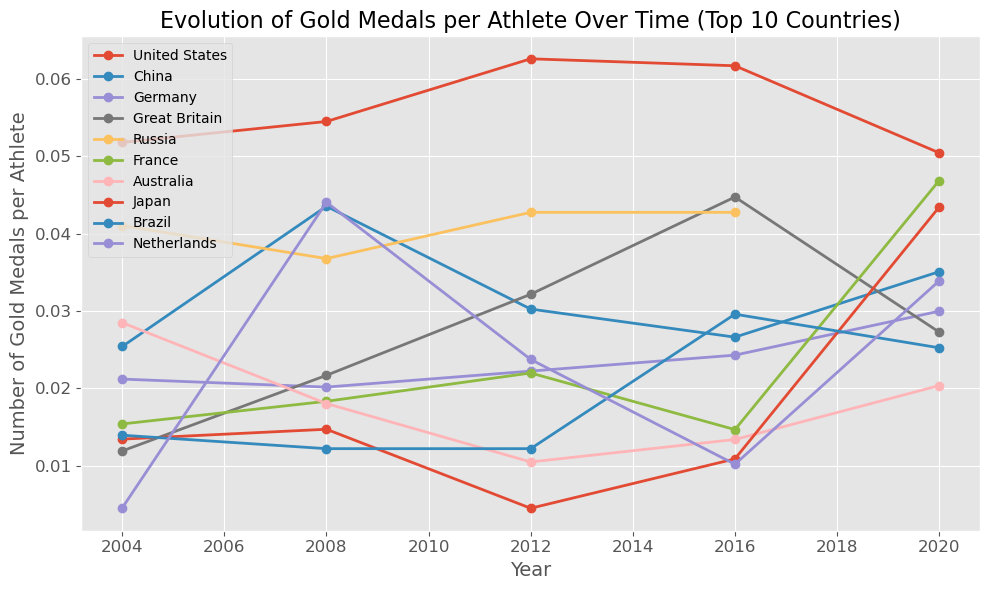

In [1268] used 3.5 MiB RAM in 0.32s (system mean cpu 9%, single max cpu 100%), peaked 3.9 MiB above final usage, current RAM usage now 1042.4 MiB


In [1268]:
import matplotlib.pyplot as plt

# Calculate the total number of athletes per country
total_athletes_per_country = df.groupby('Team')['Name'].nunique()

# Filter the data to include only gold medal winners
gold_medals = df[df['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Calculate the number of gold medals per athlete for each country and each year
gold_medals_per_athlete = gold_medals_by_year_and_country.div(total_athletes_per_country, axis=1)

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals per athlete over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_per_athlete.index, gold_medals_per_athlete[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution of Gold Medals per Athlete Over Time (Top 10 Countries)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals per Athlete', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Total Number of Medals Won by Country and Medal Type

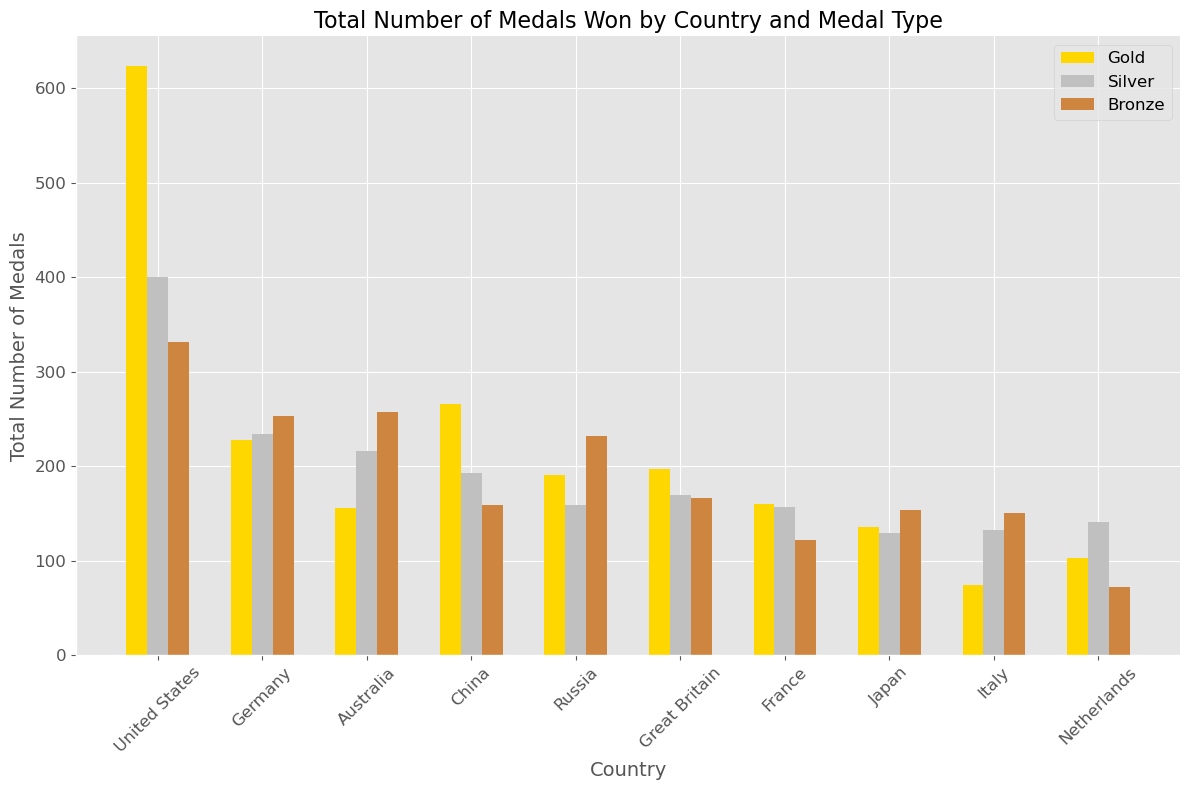

In [1269] used 1.4 MiB RAM in 0.28s (system mean cpu 10%, single max cpu 78%), peaked 0.1 MiB above final usage, current RAM usage now 1043.8 MiB


In [1269]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by country and count the total number of medals won by each country and each type of medal
medals_by_country = df.groupby(['Team', 'Medal']).size().unstack(fill_value=0)

# Select the top 10 countries with the most total medals
top_10_countries = medals_by_country.sum(axis=1).nlargest(10).index

# Select the medal types
medal_types = ['Gold', 'Silver', 'Bronze']

# Set the position of each bar on the x-axis
x = np.arange(len(top_10_countries))

# Set the width of the bars
width = 0.2

# Assign colors to each medal type
colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'}

# Plotting the grouped bar graph
plt.figure(figsize=(12, 8))  # Taille de la figure

for i, medal in enumerate(medal_types):
    plt.bar(x - width + i * width, medals_by_country.loc[top_10_countries, medal], 
            width=width, label=medal, color=colors[medal])

plt.title('Total Number of Medals Won by Country and Medal Type', fontsize=16)  # Titre
plt.xlabel('Country', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Total Number of Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(ticks=x, labels=top_10_countries, rotation=45, fontsize=12)  # Étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

# Supprimer les bordures de la figure
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(fontsize=12)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Strongest Evolution in Medals Won by Team

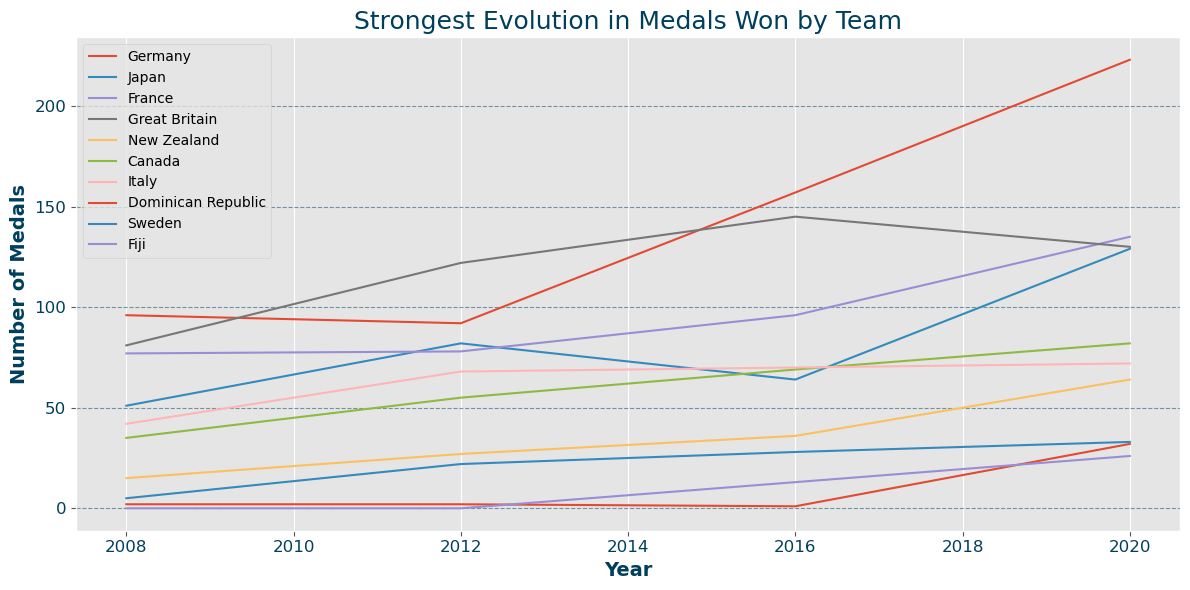

In [1270] used 2.9 MiB RAM in 0.29s (system mean cpu 9%, single max cpu 86%), peaked 0.0 MiB above final usage, current RAM usage now 1046.7 MiB


In [1270]:
# Filter the data to include only Summer Olympic Games between 2010 and 2020
summer_games = df[(df['Season'] == 'Summer') & (df['Year'] >= 2008) & (df['Year'] <= 2020)]

# Group the data by team and year, and calculate the total number of medals won by each team in each year
medals_by_year = summer_games.groupby(['Team', 'Year'])['Medal'].count().unstack()

# Calculate the difference in the number of medals won by each team between the first year and the last year
medal_difference = medals_by_year.iloc[:, -1] - medals_by_year.iloc[:, 0]

# Sort the teams based on the difference in the number of medals won in descending order
sorted_teams = medal_difference.sort_values(ascending=False)

# Select the top 5 teams with the largest increase in medals won
top_5_teams = sorted_teams.index[:10]

# Create a line chart showing the number of medals won by the top 5 teams in each year
plt.figure(figsize=(12, 6))
for team in top_5_teams:
    plt.plot(medals_by_year.loc[team], label=team)
plt.title('Strongest Evolution in Medals Won by Team', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.legend()
plt.tight_layout()
plt.show()


#### Number of Sports Over Time

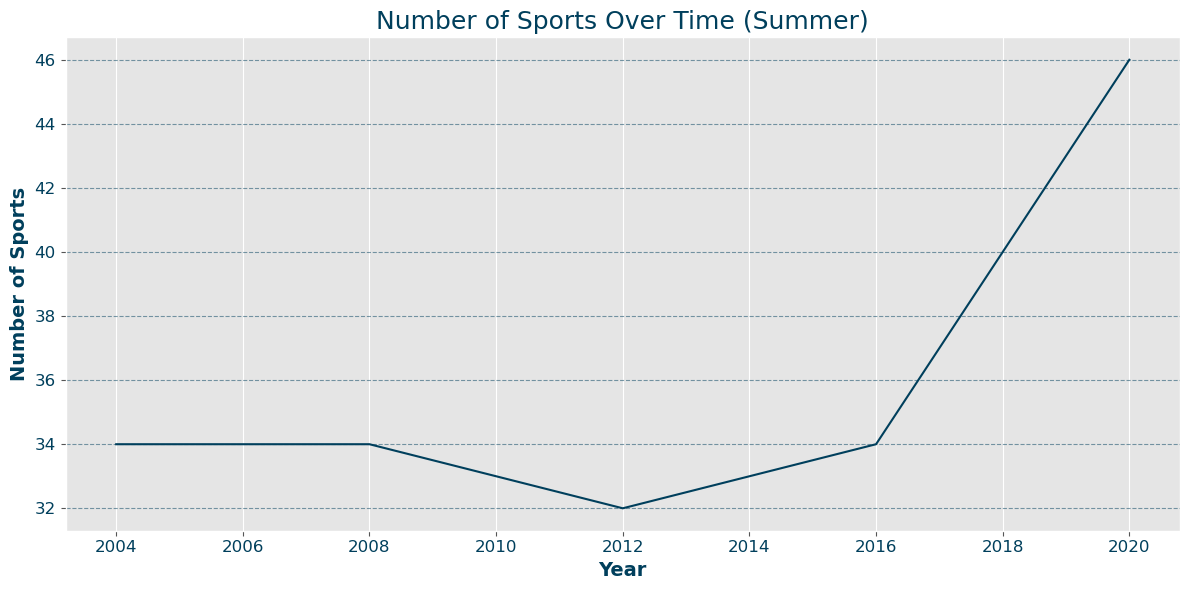

In [1271] used 2.8 MiB RAM in 0.25s (system mean cpu 9%, single max cpu 92%), peaked 2.7 MiB above final usage, current RAM usage now 1049.5 MiB


In [1271]:
summer_sports_per_year = df[df['Season'] == 'Summer'].groupby('Year')['Sport'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(summer_sports_per_year.index, summer_sports_per_year.values, color='#003f5c')
plt.title('Number of Sports Over Time (Summer)', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Sports', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.tight_layout()
plt.show()

#### Last sport that apperead with most medals

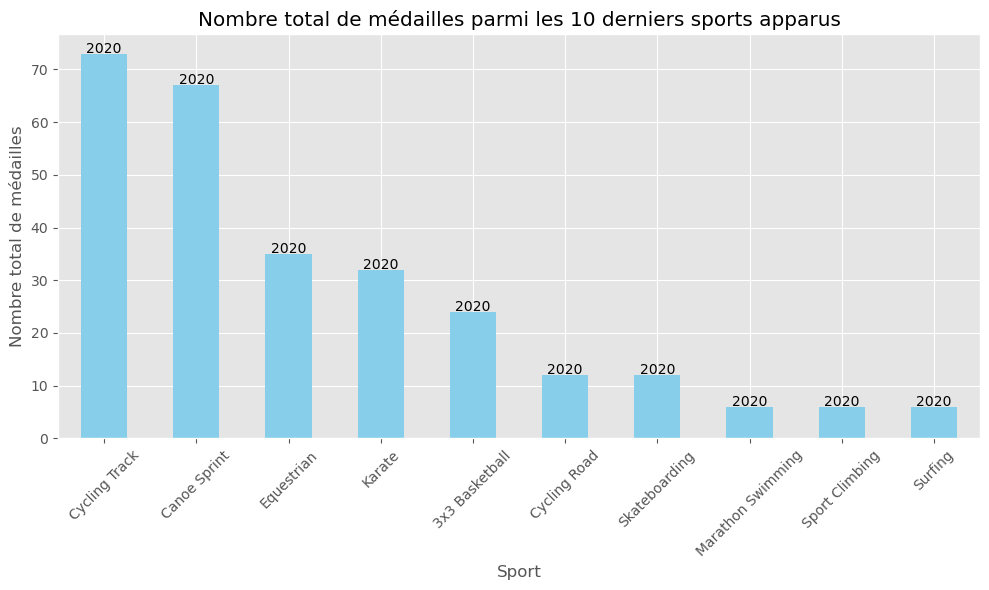

In [1272] used -0.4 MiB RAM in 0.26s (system mean cpu 14%, single max cpu 88%), peaked 2.3 MiB above final usage, current RAM usage now 1049.1 MiB


In [1272]:
# Identifier les années où chaque sport est apparu pour la première fois
first_appearance = summer_games.groupby('Sport')['Year'].min()

# Sélectionner les 10 derniers sports apparus
latest_sports = first_appearance.sort_values(ascending=False).head(10)

# Filtrer les données pour inclure seulement les médailles des 10 derniers sports
latest_sports_medals = summer_games[summer_games['Sport'].isin(latest_sports.index)]

# Compter le nombre total de médailles par sport
medal_counts = latest_sports_medals.groupby('Sport')['Medal'].count().sort_values(ascending=False)

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
bar_plot = medal_counts.plot(kind='bar', color='skyblue')

# Ajouter l'année d'apparition à chaque barre
for i, v in enumerate(medal_counts):
    sport_name = medal_counts.index[i]
    year = first_appearance[sport_name]
    bar_plot.text(i, v + 0.2, str(year), ha='center')

plt.title('Nombre total de médailles parmi les 10 derniers sports apparus')
plt.xlabel('Sport')
plt.ylabel('Nombre total de médailles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Sports with the Most Medals

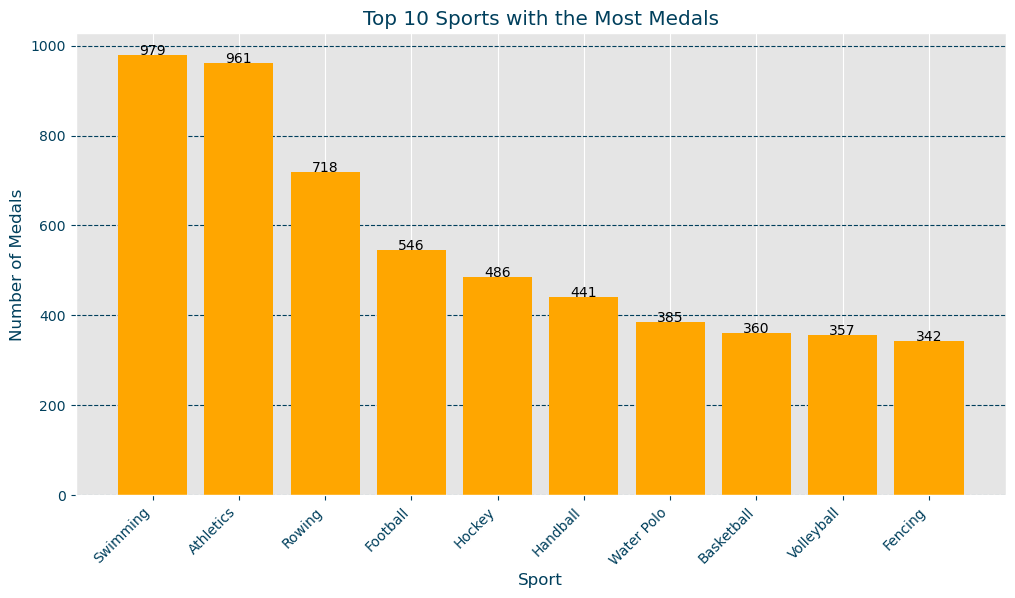

In [1273] used 2.3 MiB RAM in 0.24s (system mean cpu 9%, single max cpu 50%), peaked 2.8 MiB above final usage, current RAM usage now 1051.4 MiB


In [1273]:
top_10_sports = df.groupby('Sport')['Medal'].count().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_sports.index, top_10_sports.values, color='#ffa600')
ax.set_title('Top 10 Sports with the Most Medals', color='#003f5c')
ax.set_xlabel('Sport', color='#003f5c')
ax.set_ylabel('Number of Medals', color='#003f5c')
ax.tick_params(axis='both', colors='#003f5c')
ax.grid(axis='y', linestyle='--', color='#003f5c')

for i, sport in enumerate(top_10_sports.index):
    ax.text(i, top_10_sports[sport] + 0.5, str(top_10_sports[sport]), color='black', ha='center')

plt.xticks(rotation=45, ha='right')
plt.show()


#### Top 10 Athletes with Most Medals

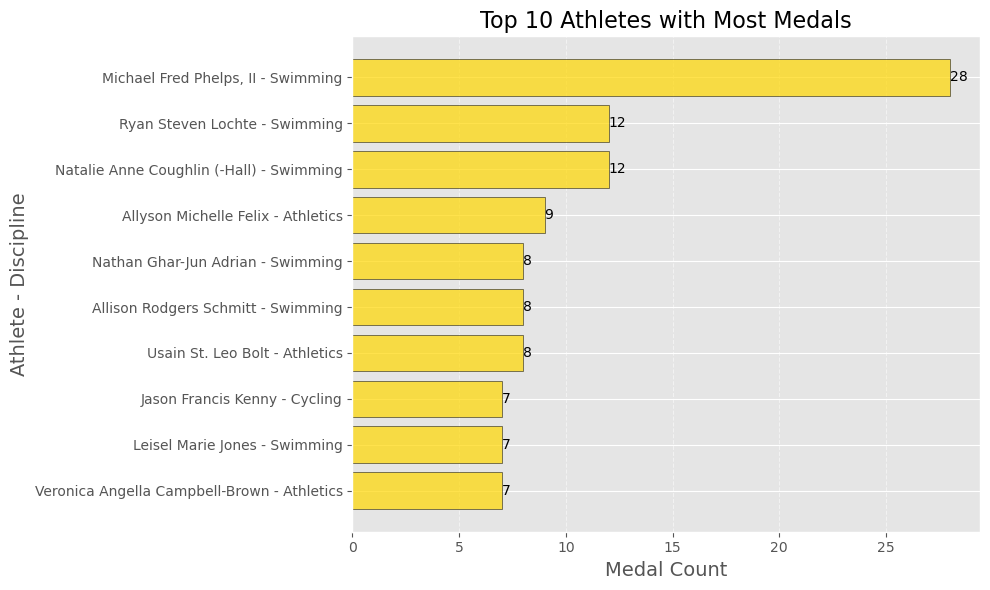

In [1274] used 2.3 MiB RAM in 0.26s (system mean cpu 15%, single max cpu 50%), peaked 2.2 MiB above final usage, current RAM usage now 1053.7 MiB


In [1274]:
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_athletes['Athlete'] + ' - ' + top_10_athletes['Sport'], 
                top_10_athletes['Medal Count'], color='gold', edgecolor='black', alpha=0.7)

# Add the number of medals in the middle of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10)

plt.xlabel('Medal Count', fontsize=14)
plt.ylabel('Athlete - Discipline', fontsize=14)  # Updated ylabel
plt.title('Top 10 Athletes with Most Medals', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the athlete with most medals on top
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Fusion des bases + Nettoyage

In [1286]:
df = pd.read_csv("data/athlete_events.csv")
df = df[(df['Year'] > 2000) & (df['Season'] == 'Summer')]

# Merge df with dictionary_df based on the 'Team' column in df and the 'Country' column in dictionary_df
merged_df = pd.merge(df, dictionary, left_on='Team', right_on='Country', how='left')

# Merge merged_df with region_df based on the 'NOC' column in merged_df and the 'NOC' column in region_df
final_merged_df = pd.merge(merged_df, region_df, on='NOC', how='left')

In [1286] used 8.7 MiB RAM in 0.53s (system mean cpu 7%, single max cpu 100%), peaked 30.2 MiB above final usage, current RAM usage now 1075.4 MiB


In [1287]:
final_merged_df.drop(columns=['notes'], inplace=True)
final_merged_df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Code,Population,GDP per Capita,region
0,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,CHN,1.371220e+09,8027.683810,China
1,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NOR,5.195921e+06,74400.369777,Norway
2,Andreea Aanei,F,22.0,170.0,125.0,Romania,ROU,2016 Summer,2016,Summer,Rio de Janeiro,Weightlifting,Weightlifting Women's Super-Heavyweight,NaN,Romania,ROM,1.983239e+07,8972.922518,Romania
3,Fritz Aanes,M,26.0,187.0,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",NaN,Norway,NOR,5.195921e+06,74400.369777,Norway
4,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.0,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",NaN,France,FRA,6.680838e+07,36205.568102,France


In [1287] used -1.0 MiB RAM in 0.12s (system mean cpu 3%, single max cpu 14%), peaked 1.0 MiB above final usage, current RAM usage now 1074.4 MiB


## 3.2. Nettoyer les données

### 3.2.1. Données manquantes

In [1288]:
# Vérification des valeurs NULL 
df.isnull().sum() 

Name          0
Sex         159
Age         161
Height     7720
Weight    12653
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport       159
Event      9492
Medal     55132
dtype: int64

In [1288] used 0.3 MiB RAM in 0.12s (system mean cpu 5%, single max cpu 13%), peaked 0.0 MiB above final usage, current RAM usage now 1074.7 MiB


#### Traitement des valeurs nulles


In [1290]:
df[df['Name'] == 'Ragnhild Margrethe Aamodt']

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
79,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold


In [1290] used 0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 13%), peaked 0.0 MiB above final usage, current RAM usage now 1075.5 MiB


In [1291]:
from sklearn.impute import SimpleImputer

df_male = df[df['Sex'] == 'M']
df_female = df[df['Sex'] == 'F']
columns_to_impute = ['Age', 'Height', 'Weight']

# Créer un imputer avec la stratégie 'mean' pour remplacer les valeurs nulles par la moyenne
imputer = SimpleImputer(strategy='mean')

df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])

df = pd.concat([df_male, df_female])


In [1291] used 2.8 MiB RAM in 0.14s (system mean cpu 2%, single max cpu 8%), peaked 0.0 MiB above final usage, current RAM usage now 1078.3 MiB


C:\Users\guill\AppData\Local\Temp\ipykernel_22676\2023318409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
C:\Users\guill\AppData\Local\Temp\ipykernel_22676\2023318409.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])


In [1292]:
df[df['Name'] == 'Ragnhild Margrethe Aamodt']

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
79,Ragnhild Margrethe Aamodt,F,27.0,163.0,61.723618,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold


In [1292] used 0.1 MiB RAM in 0.11s (system mean cpu 3%, single max cpu 11%), peaked 0.0 MiB above final usage, current RAM usage now 1078.4 MiB


In [1293]:
df.isnull().sum()

Name          0
Sex           0
Age           0
Height        0
Weight        0
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event      9333
Medal     54973
dtype: int64

In [1293] used -2.0 MiB RAM in 0.15s (system mean cpu 2%, single max cpu 3%), peaked 0.0 MiB above final usage, current RAM usage now 1076.4 MiB


### 3.2.2. Valeurs atypiques (outliers)

Tracer, en un graphique, le boxplot des variables numériques : 